# Dogs vs Cats - features

[Kaggle](https://www.kaggle.com/c/dogs-vs-cats)

1 = dog

0 = cat

Notes for report:
    analyse how the variability of nr_features affects
    try different detectors

In [84]:
import cv2
from matplotlib import pyplot as plt
import sklearn
import numpy as np
import pickle as pk
from os import listdir

plt.style.use('ggplot')
%matplotlib inline

In [85]:
NR_SAMPLES = 100
NR_WORDS = 500

### Load training dataset

In [8]:
train_folder = 'data/train/'

In [9]:
imgs_paths = [train_folder + filepath for filepath in listdir(train_folder)]

In [52]:
# select a subset
imgs_paths = imgs_paths[:NR_SAMPLES]

In [11]:
from os import listdir

def load_images(imgs_paths, gray=False):
    for path in imgs_paths:
        img = cv2.imread(path)
        
        if gray:
            yield cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        else:
            yield cv2.imread(path)

In [12]:
labels = [1 if "dog" in path else 0 for path in imgs_paths]

In [13]:
print('Nr dogs:', labels.count(1))

Nr dogs: 52


In [14]:
print('Nr cats:', labels.count(0))

Nr cats: 48


## Features Extraction

#### Features detectors, descriptors and matcher

In [15]:
# SIFT features detector and extractor
sift = cv2.xfeatures2d.SIFT_create()

In [16]:
# SURF features detector and extractor
surf = cv2.xfeatures2d.SURF_create()

In [17]:
# FAST features detector
fast = cv2.FastFeatureDetector_create()

In [18]:
# BRISK descriptors extractor
br = cv2.BRISK_create()

In [19]:
# FLANN matcher
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

#### Bag of Words

In [1]:
def train_bow(imgs, detector, matcher, extractor=None):
    if extractor == None:
        extractor = detector
    
    bow_trainer = cv2.BOWKMeansTrainer(NR_WORDS, 
                                       attempts=1, 
                                       flags=cv2.KMEANS_PP_CENTERS)
    
    bow_extractor = cv2.BOWImgDescriptorExtractor(extractor, matcher)
    
    for img in load_images(imgs, gray=True):
        
        kp = detector.detect(img)
        kp, des = extractor.compute(img, kp)
        
        bow_trainer.add(des)
        
    vocabulary = bow_trainer.cluster()
    
    pk.dump(vocabulary, open('vocabulary.p', 'wb'))
    
    vocabulary = pk.load(open('vocabulary', 'rb'))
    
    bow_extractor.setVocabulary(vocabulary)
    
    return bow_extractor

In [38]:
detector = sift
extractor = sift

In [39]:
sift_bow_extractor = train_bow(imgs_paths, detector, flann, extractor=extractor)

In [40]:
features = np.empty((0, NR_WORDS))
imgs = load_images(imgs_paths, gray=True)

for img in imgs:
    kp = detector.detect(img)
    
    img_features = sift_bow_extractor.compute(img, kp)
    
    features = np.concatenate((features, img_features), axis=0)

In [41]:
features.shape

(100, 100)

In [42]:
labels = np.asarray(labels)

labels.shape

(100,)

In [43]:
target_names = ['dog', 'cat']

## Prediction

In [44]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.base import clone as skl_clone
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def k_fold_model_select(features, labels, raw_classifiers, n_folds=10, weigh_samples_fn=None): 
    # weigh_samples_fn is explained below
    # assumes that the raw_classifier output is in probability
    
    # split into training and test data
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels,
                                                        test_size=0.3,
                                                        stratify=labels,
                                                        random_state=0)
    
    
    # use stratified k-fold cross validation to select the model
    skf = StratifiedKFold(y_train, n_folds=n_folds)

    best_classifier = None
    best_score = float('-inf')

    for train_index, validation_index in skf:
        for raw_classifier in raw_classifiers:
            classifier = skl_clone(raw_classifier)
            classifier = classifier.fit(X_train[train_index], y_train[train_index])

            if weigh_samples_fn != None:
                y_pred = classifier.predict(X_train[validation_index])
                sample_weight = weigh_samples_fn(y_train[validation_index], y_pred)
            else:
                sample_weight = None

            score = accuracy_score(classifier.predict(X_train[validation_index]), y_train[validation_index],
                                     sample_weight=sample_weight)

            if score > best_score:
                best_classifier = classifier
                best_score = score
    
    # compute the confusion matrix
    y_pred = best_classifier.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    
    # now compute the score for the test data of the best found classifier
    if weigh_samples_fn != None:
        sample_weight = weigh_samples_fn(y_test, y_pred)
    else:
        sample_weight = None
    test_score = accuracy_score(best_classifier.predict(X_test), y_test, sample_weight=sample_weight)
    
    # obtain the classification report
    report = classification_report(y_test, y_pred, target_names=['cat', 'dog'], sample_weight=sample_weight)
    
    # obtain ROC curve
    y_test_bin = label_binarize(y_test, classes=[0, 1])
    y_prob = best_classifier.predict_proba(X_test)
    
    #fpr, tpr, _ = roc_curve(y_test_bin[:, 1], y_prob[:, 1])
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, 1])
    roc_info = (best_classifier.__class__.__name__, (fpr, tpr))
    
    return (test_score, report, conf_mat, roc_info, best_classifier)

#### Nearest Neighbors

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(weights='distance', algorithm='auto')
knn_score, knn_rep, knn_cm, knn_roc, knn_clf = k_fold_model_select(features, labels, [knn])

print("Nearest Neighbors")
print("Score:", knn_score)
print("Confusion matrix:", knn_cm, sep='\n')
print("Classification report:", knn_rep, sep='\n')

Score: 0.533333333333
Confusion matrix:
[[ 0 14]
 [ 0 16]]
Classification report:
             precision    recall  f1-score   support

        cat       0.00      0.00      0.00        14
        dog       0.53      1.00      0.70        16

avg / total       0.28      0.53      0.37        30



/home/diogo/bin/anaconda3/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Gaussian Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb_score, nb_rep, nb_cm, nb_roc, nb_clf = k_fold_model_select(features, labels, [nb])

print("Gaussian Naive Bayes")
print("Score:", nb_score)
print("Confusion matrix:", nb_cm, sep='\n')
print("Classification report:", nb_rep, sep='\n')

Score: 0.533333333333
Confusion matrix:
[[13  1]
 [13  3]]
Classification report:
             precision    recall  f1-score   support

        cat       0.50      0.93      0.65        14
        dog       0.75      0.19      0.30        16

avg / total       0.63      0.53      0.46        30



#### SVM

In [47]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

svc = SVC(kernel='linear', random_state=0, class_weight='balanced', probability=True)

pipeline = Pipeline([
        ('min/max scaler', MinMaxScaler(feature_range=(0.0, 1.0))),
        ('svc linear', svc)])

svc_score, svc_rep, svc_cm, svc_roc, svc_clf = \
    k_fold_model_select(features, labels, [pipeline])

print("SVM")
print("Score:", svc_score)
print("Confusion matrix:", svc_cm, sep='\n')
print("Classification report:", svc_rep, sep='\n')

Score: 0.533333333333
Confusion matrix:
[[ 0 14]
 [ 0 16]]
Classification report:
             precision    recall  f1-score   support

        cat       0.00      0.00      0.00        14
        dog       0.53      1.00      0.70        16

avg / total       0.28      0.53      0.37        30



/home/diogo/bin/anaconda3/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### AdaBoost

In [48]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(min_samples_split=15, random_state=0, min_samples_leaf=5, class_weight='balanced')

ab = AdaBoostClassifier(base_estimator=dt, random_state=0)
ab_score, ab_rep, ab_cm, ab_roc, ab_clf = k_fold_model_select( features, labels, [ab])

print("AdaBoos")
print("Score:", ab_score)
print("Confusion matrix:", ab_cm, sep='\n')
print("Classification report:", ab_rep, sep='\n')

Score: 0.533333333333
Confusion matrix:
[[ 0 14]
 [ 0 16]]
Classification report:
             precision    recall  f1-score   support

        cat       0.00      0.00      0.00        14
        dog       0.53      1.00      0.70        16

avg / total       0.28      0.53      0.37        30



/home/diogo/bin/anaconda3/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)

rf_score, rf_rep, rf_cm, rf_roc, rf_clf = k_fold_model_select(features, labels, [rf])

print("Random Forest")
print("Score:", rf_score)
print("Confusion matrix:", rf_cm, sep='\n')
print("Classification report:", rf_rep, sep='\n')

Score: 0.533333333333
Confusion matrix:
[[ 0 14]
 [ 0 16]]
Classification report:
             precision    recall  f1-score   support

        cat       0.00      0.00      0.00        14
        dog       0.53      1.00      0.70        16

avg / total       0.28      0.53      0.37        30



/home/diogo/bin/anaconda3/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Selecting the Best

In [86]:
classifiers = [knn_clf, nb_clf, svc_clf, ab_clf, rf_clf]

In [88]:
best_score, best_rep, best_cm, best_roc, best_clf = k_fold_model_select(features, labels, classifiers)

print("Classifier:", best_clf.__class__.__name__)
print("Score:", best_score)
print("Confusion matrix:", best_cm, sep='\n')
print("Classification report:", best_rep, sep='\n')

Classifier: KNeighborsClassifier
Score: 0.533333333333
Confusion matrix:
[[ 0 14]
 [ 0 16]]
Classification report:
             precision    recall  f1-score   support

        cat       0.00      0.00      0.00        14
        dog       0.53      1.00      0.70        16

avg / total       0.28      0.53      0.37        30



/home/diogo/bin/anaconda3/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
import pickle as pk

pk.dump(best_clf, open('best_clf.p', 'wb'))

## ROC Curves

In [50]:
def plot_roc_curves(roc_curves):
    for name, (fpr, tpr) in roc_curves:
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC for {} (area = {:0.2f})'.format(name, roc_auc))
        
    plt.legend(bbox_to_anchor=(2.1, 1.05))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

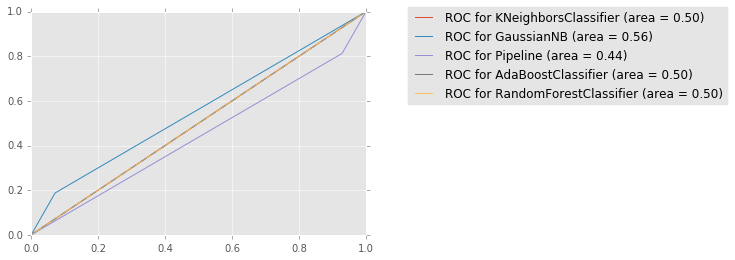

In [51]:
roc_curves = [knn_roc, nb_roc, svc_roc, ab_roc, rf_roc]

plot_roc_curves(roc_curves)

## Testing

In [125]:
def save_labels_csv(labels):
    indexed_labels = np.concatenate((np.asmatrix(range(1, len(labels) + 1)).transpose(), np.asmatrix(labels)), axis=1)
    
    np.savetxt('result.csv', 
               indexed_labels,
               fmt='%d',
               delimiter=',',
               header='id,label',
               comments='')

In [111]:
test_folder = 'data/test1/'

In [130]:
test_imgs_paths = [test_folder + filepath for filepath in listdir(test_folder)]

In [131]:
test_imgs_paths = test_imgs_paths[:10]

In [132]:
pred = []

test_imgs = load_images(test_imgs_paths, gray=True)

for img in test_imgs:
    
    kp = detector.detect(img)
    img_features = sift_bow_extractor.compute(img, kp)
    
    p = best_clf.predict(img_features)
    
    pred.append(p)

In [133]:
save_labels_csv(pred)

[[ 1  1]
 [ 2  1]
 [ 3  1]
 [ 4  1]
 [ 5  1]
 [ 6  1]
 [ 7  1]
 [ 8  1]
 [ 9  1]
 [10  1]]
